## Combining Technical Indicator and LSTM for stock selection and prediction

#### RSI
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. 

#### SMA
Simple Moving Average (SMA)are one of the core indicators in technical analysis, and there are a variety of different versions. SMA is the easiest moving average to construct. It is simply the average price over the specified period.

#### LSTM
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Here, the LSTM is used in this work to forecast future stock prices. The STM is designed to solve
vanish gradient problem during back propagation of recurrent neural network (RNN) so LSTM can reduce effect of short-
term memory.

#### Steps followed:
Step1 : Web scrape the list of S&P stocks and fetch 2 years historical data <br>
Step2 : Calculate the value of RSI-14 & SMA 20,50,100,200  <br>
Step3 : Categorize the stocks into oversold or overbought and sort according to the values Select top 3(overbought) & bottom 3(Oversold) <br>
Step4 : Create data frame by combining the values of RSI and SMA , close price and label future close <br>
Step5 : Input data with a memory of 10 days into LSTM and fine tune paramaters for each stocks to build the model. <br>
Step6 : Forecast for next day. <br>


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta

import itertools

from tqdm.notebook import tqdm_notebook
import time

import plotly.express as px
# !pip install tqdm
# !pip install time

In [3]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA



##### Step1 : Web scrape the list of S&P stocks and fetch 2 years historical data <br>

In [3]:
# List of S&P stocks are fetched from wikipedia and symbols are extracted
#payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
#first_table = payload[0]
#second_table = payload[1]
#symbols = first_table['Symbol'].values.tolist()

In [4]:
#pd.DataFrame({"symbols":first_table['Symbol'].values}).to_csv("./symbols.csv")


In [4]:
# Using yahoo finance API download historical stock values
start = datetime.date.today() - relativedelta(years=2)
end = datetime.date.today() 
symbolscsv = pd.read_csv('symbols.csv')
symbols = symbolscsv['symbols'].values.tolist()

stock_data = yf.download(symbols,start=start,end = end, interval='1d')

stock_data = stock_data.dropna(how='all').dropna(axis=1)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [5]:
stock_close,stock_volume = stock_data["Close"],stock_data["Volume"]

In [6]:
stock_close = stock_data["Close"].

AttributeError: 'DataFrame' object has no attribute 'avg'

In [7]:
stock_close

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-06,74.360001,9.500000,95.809998,65.617500,75.730003,86.290001,150.259995,82.730003,166.050003,319.130005,...,56.730000,61.150002,40.470001,37.730000,65.190002,70.500000,95.087379,191.850006,26.930000,126.790001
2020-04-07,74.029999,10.220000,99.440002,64.857498,75.389999,87.199997,152.779999,81.930000,164.119995,308.929993,...,60.849998,59.230000,41.240002,38.090000,66.190002,71.349998,98.941750,192.360001,28.040001,126.110001
2020-04-08,76.690002,11.330000,102.519997,66.517502,78.559998,88.330002,156.270004,84.949997,171.729996,317.179993,...,69.070000,62.799999,43.849998,39.580002,69.089996,75.370003,108.038834,196.649994,29.440001,127.250000
2020-04-09,78.330002,12.510000,106.860001,66.997498,79.750000,87.809998,160.080002,86.040001,177.919998,318.700012,...,70.650002,66.269997,43.130001,41.869999,69.339996,80.370003,107.145630,201.220001,31.000000,128.750000
2020-04-13,76.209999,11.560000,110.000000,68.312500,80.300003,85.449997,156.389999,85.849998,172.570007,320.649994,...,69.300003,63.660000,42.759998,40.240002,68.190002,77.059998,104.873787,197.910004,30.080000,122.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30,135.460007,18.049999,211.820007,177.770004,163.750000,155.139999,328.510010,120.379997,338.459991,460.059998,...,81.169998,72.320000,83.779999,49.549999,88.099998,120.839996,128.690002,429.609985,67.370003,191.320007
2022-03-31,132.330002,18.250000,206.960007,174.610001,162.110001,154.710007,331.239990,118.360001,337.230011,455.619995,...,79.739998,72.169998,82.589996,49.220001,85.260002,118.529999,127.900002,413.700012,65.559998,188.589996
2022-04-01,133.970001,18.240000,207.479996,174.309998,162.679993,156.520004,338.640015,118.580002,340.640015,458.190002,...,80.629997,72.750000,83.120003,49.250000,86.230003,118.820000,127.730003,413.730011,64.300003,191.110001


In [8]:
stock_volume

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-06,2312000.0,94272300.0,1378300.0,201820400.0,10266500.0,1514800.0,574800.0,12373800.0,3090000.0,5145100.0,...,9013400.0,4525600.0,41301900.0,4434400.0,1802800.0,3683700.0,2710960.0,306400.0,3579700.0,3419900.0
2020-04-07,2458000.0,138061000.0,1255800.0,202887200.0,11591700.0,1311100.0,938200.0,10872100.0,3002500.0,5422300.0,...,12004600.0,3916500.0,48921800.0,2516400.0,1361600.0,3908500.0,3112042.0,413600.0,4383300.0,3075000.0
2020-04-08,2703000.0,82718700.0,680900.0,168895200.0,12218500.0,1729500.0,581000.0,9266400.0,2466200.0,4002500.0,...,10758100.0,2771200.0,33355600.0,2394200.0,1295600.0,3682000.0,3025316.0,252300.0,3181400.0,2478400.0
2020-04-09,2399900.0,117592800.0,1137200.0,161834800.0,9425900.0,1348700.0,501100.0,10466800.0,3743700.0,3290200.0,...,11008300.0,4319300.0,60107300.0,3700300.0,1350000.0,4199600.0,2119946.0,529300.0,5445500.0,1962300.0
2020-04-13,1533000.0,73385500.0,1175500.0,131022800.0,9293500.0,2118700.0,445800.0,6665800.0,1918500.0,1839000.0,...,7528100.0,2401800.0,29651900.0,2754200.0,779000.0,2014500.0,1167196.0,331700.0,3218900.0,3188900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30,1439800.0,28866400.0,716800.0,92633200.0,5151800.0,751700.0,175500.0,4064800.0,1721600.0,3889200.0,...,1456900.0,1582100.0,22079000.0,1735800.0,720500.0,2022800.0,1150200.0,316500.0,1257100.0,2612700.0
2022-03-31,3046400.0,33338200.0,727800.0,103049300.0,8670100.0,1052400.0,431200.0,5432600.0,2752600.0,4141300.0,...,2382900.0,3045300.0,27861500.0,1677900.0,1415500.0,3932200.0,1363100.0,575600.0,1578300.0,2477600.0
2022-04-01,1466900.0,25106700.0,693400.0,78699800.0,5702500.0,822800.0,225400.0,4314000.0,2090300.0,2716800.0,...,3116600.0,2598100.0,18665800.0,1838400.0,913200.0,2884000.0,1616900.0,505200.0,2479500.0,1831400.0


##### Step2 : Calculate the value of RSI-14 & SMA 20,50,100,200  <br>

In [9]:
Stock_Close_ForRSI = stock_close.iloc[-15:,:]
Stock_Close_ForRSI

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,135.000000,16.469999,207.520004,159.589996,156.050003,150.500000,294.529999,119.480003,324.910004,442.359985,...,75.169998,69.250000,76.930000,48.619999,87.099998,119.550003,121.989998,401.649994,68.860001,191.919998
2022-03-17,136.820007,16.549999,208.179993,160.619995,158.589996,152.199997,307.649994,121.199997,319.500000,444.359985,...,76.910004,69.699997,78.980003,48.759998,88.099998,119.029999,122.279999,419.350006,68.339996,193.679993
2022-03-18,139.119995,16.750000,206.339996,163.979996,159.199997,152.000000,304.329987,122.449997,323.950012,453.329987,...,79.650002,68.790001,78.669998,48.660000,88.070000,121.989998,120.769997,437.179993,67.849998,195.899994
2022-03-21,138.139999,16.090000,205.750000,165.380005,160.050003,153.179993,306.739990,121.760002,324.500000,453.589996,...,78.300003,69.320000,82.199997,49.250000,87.660004,118.540001,121.040001,429.540009,67.760002,194.710007
2022-03-22,139.289993,16.559999,209.399994,168.820007,160.009995,152.110001,313.339996,121.889999,327.470001,466.450012,...,79.930000,69.209999,81.839996,49.680000,88.690002,118.669998,120.480003,433.679993,69.529999,196.880005
2022-03-23,134.179993,16.209999,213.339996,170.210007,158.419998,151.529999,311.029999,116.919998,320.500000,422.899994,...,78.639999,69.300003,83.129997,49.490002,86.540001,115.959999,120.739998,419.910004,67.699997,191.229996
2022-03-24,136.410004,16.719999,214.669998,174.070007,160.279999,152.610001,321.470001,117.820000,325.290009,432.140015,...,81.370003,69.879997,83.379997,49.189999,86.339996,119.699997,124.150002,427.369995,68.580002,189.570007
2022-03-25,135.710007,17.010000,215.580002,174.720001,161.330002,154.690002,318.880005,118.949997,327.709991,431.619995,...,80.269997,70.699997,85.199997,49.689999,86.690002,119.620003,125.279999,425.660004,71.080002,189.429993
2022-03-28,135.419998,17.299999,210.490005,175.600006,161.970001,154.729996,321.809998,119.989998,330.739990,450.010010,...,80.129997,71.239998,82.809998,49.840000,86.849998,121.190002,125.680000,422.279999,69.730003,189.369995


In [10]:
SP500_diff = pd.DataFrame()
SP500_diff["Date"] = Stock_Close_ForRSI.index
SP500_diff = SP500_diff.set_index("Date")
for col in Stock_Close_ForRSI.columns:
    SP500_diff[col] = Stock_Close_ForRSI[col].diff()

SP500_diff

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,1.820007,0.080000,0.659988,1.029999,2.539993,1.699997,13.119995,1.719994,-5.410004,2.000000,...,1.740005,0.449997,2.050003,0.139999,1.000000,-0.520004,0.290001,17.700012,-0.520004,1.759995
2022-03-18,2.299988,0.200001,-1.839996,3.360001,0.610001,-0.199997,-3.320007,1.250000,4.450012,8.970001,...,2.739998,-0.909996,-0.310005,-0.099998,-0.029999,2.959999,-1.510002,17.829987,-0.489998,2.220001
2022-03-21,-0.979996,-0.660000,-0.589996,1.400009,0.850006,1.179993,2.410004,-0.689995,0.549988,0.260010,...,-1.349998,0.529999,3.529999,0.590000,-0.409996,-3.449997,0.270004,-7.639984,-0.089996,-1.189987
2022-03-22,1.149994,0.469999,3.649994,3.440002,-0.040009,-1.069992,6.600006,0.129997,2.970001,12.860016,...,1.629997,-0.110001,-0.360001,0.430000,1.029999,0.129997,-0.559998,4.139984,1.769997,2.169998
2022-03-23,-5.110001,-0.350000,3.940002,1.389999,-1.589996,-0.580002,-2.309998,-4.970001,-6.970001,-43.550018,...,-1.290001,0.090004,1.290001,-0.189999,-2.150002,-2.709999,0.259995,-13.769989,-1.830002,-5.650009
2022-03-24,2.230011,0.510000,1.330002,3.860001,1.860001,1.080002,10.440002,0.900002,4.790009,9.240021,...,2.730003,0.579994,0.250000,-0.300003,-0.200005,3.739998,3.410004,7.459991,0.880005,-1.659988
2022-03-25,-0.699997,0.290001,0.910004,0.649994,1.050003,2.080002,-2.589996,1.129997,2.419983,-0.520020,...,-1.100006,0.820000,1.820000,0.500000,0.350006,-0.079994,1.129997,-1.709991,2.500000,-0.140015
2022-03-28,-0.290009,0.289999,-5.089996,0.880005,0.639999,0.039993,2.929993,1.040001,3.029999,18.390015,...,-0.139999,0.540001,-2.389999,0.150002,0.159996,1.570000,0.400002,-3.380005,-1.349998,-0.059998


The average gain or loss used in the calculation is the average percentage gain or loss during a look-back period. The formula uses a positive value for the average loss. Periods with price losses are counted as 0 in the calculations of average gain, and periods when the price increases are counted as 0 for the calculation of average losses.

In [11]:
# Calculating average gain and average loss
SP500_gain = SP500_diff.clip(lower=0)
SP500_loss = -1 * SP500_diff.clip(upper=0)

In [12]:
print("SP500_Gain")
display(SP500_gain)

print("SP500_Loss")
display(SP500_loss)

SP500_Gain


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,1.820007,0.080000,0.659988,1.029999,2.539993,1.699997,13.119995,1.719994,0.000000,2.000000,...,1.740005,0.449997,2.050003,0.139999,1.000000,0.000000,0.290001,17.700012,0.000000,1.759995
2022-03-18,2.299988,0.200001,0.000000,3.360001,0.610001,0.000000,0.000000,1.250000,4.450012,8.970001,...,2.739998,0.000000,0.000000,0.000000,0.000000,2.959999,0.000000,17.829987,0.000000,2.220001
2022-03-21,0.000000,0.000000,0.000000,1.400009,0.850006,1.179993,2.410004,0.000000,0.549988,0.260010,...,0.000000,0.529999,3.529999,0.590000,0.000000,0.000000,0.270004,0.000000,0.000000,0.000000
2022-03-22,1.149994,0.469999,3.649994,3.440002,0.000000,0.000000,6.600006,0.129997,2.970001,12.860016,...,1.629997,0.000000,0.000000,0.430000,1.029999,0.129997,0.000000,4.139984,1.769997,2.169998
2022-03-23,0.000000,0.000000,3.940002,1.389999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090004,1.290001,0.000000,0.000000,0.000000,0.259995,0.000000,0.000000,0.000000
2022-03-24,2.230011,0.510000,1.330002,3.860001,1.860001,1.080002,10.440002,0.900002,4.790009,9.240021,...,2.730003,0.579994,0.250000,0.000000,0.000000,3.739998,3.410004,7.459991,0.880005,0.000000
2022-03-25,0.000000,0.290001,0.910004,0.649994,1.050003,2.080002,0.000000,1.129997,2.419983,0.000000,...,0.000000,0.820000,1.820000,0.500000,0.350006,0.000000,1.129997,0.000000,2.500000,0.000000
2022-03-28,0.000000,0.289999,0.000000,0.880005,0.639999,0.039993,2.929993,1.040001,3.029999,18.390015,...,0.000000,0.540001,0.000000,0.150002,0.159996,1.570000,0.400002,0.000000,0.000000,0.000000


SP500_Loss


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,5.410004,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.520004,-0.000000,-0.000000,0.520004,-0.000000
2022-03-18,-0.000000,-0.000000,1.839996,-0.000000,-0.000000,0.199997,3.320007,-0.000000,-0.000000,-0.000000,...,-0.000000,0.909996,0.310005,0.099998,0.029999,-0.000000,1.510002,-0.000000,0.489998,-0.000000
2022-03-21,0.979996,0.660000,0.589996,-0.000000,-0.000000,-0.000000,-0.000000,0.689995,-0.000000,-0.000000,...,1.349998,-0.000000,-0.000000,-0.000000,0.409996,3.449997,-0.000000,7.639984,0.089996,1.189987
2022-03-22,-0.000000,-0.000000,-0.000000,-0.000000,0.040009,1.069992,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,0.110001,0.360001,-0.000000,-0.000000,-0.000000,0.559998,-0.000000,-0.000000,-0.000000
2022-03-23,5.110001,0.350000,-0.000000,-0.000000,1.589996,0.580002,2.309998,4.970001,6.970001,43.550018,...,1.290001,-0.000000,-0.000000,0.189999,2.150002,2.709999,-0.000000,13.769989,1.830002,5.650009
2022-03-24,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,0.300003,0.200005,-0.000000,-0.000000,-0.000000,-0.000000,1.659988
2022-03-25,0.699997,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,2.589996,-0.000000,-0.000000,0.520020,...,1.100006,-0.000000,-0.000000,-0.000000,-0.000000,0.079994,-0.000000,1.709991,-0.000000,0.140015
2022-03-28,0.290009,-0.000000,5.089996,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.139999,-0.000000,2.389999,-0.000000,-0.000000,-0.000000,-0.000000,3.380005,1.349998,0.059998


In [13]:
SP500_AvgGain = SP500_gain.rolling(window=14).mean()
print("SP500 - Average Gain")
display(SP500_AvgGain)


SP500_AvgLoss = SP500_loss.rolling(window=14).mean()
print("SP500 - Average Loss")
display(SP500_AvgLoss)

SP500 - Average Gain


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SP500 - Average Loss


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
SP500_RSI = pd.concat([SP500_AvgGain.iloc[-1], SP500_AvgLoss.iloc[-1]], axis=1)

SP500_RSI.columns = ["AvgGain","AvgLoss"]

SP500_RSI

,AvgGain,AvgLoss
A,0.927143,1.051429
AAL,0.207143,0.109286
AAP,1.457855,1.157142
AAPL,1.678573,0.573572
ABBV,0.817142,0.290000
...,...,...
YUM,0.694285,0.830714
ZBH,0.923572,0.413571
ZBRA,5.749283,4.172854
ZION,0.390000,0.708571


In [15]:
SP500_RSI["rs"] = round(SP500_RSI["AvgGain"]/SP500_RSI["AvgLoss"],2)

SP500_RSI["rsi"] = 100 - (100 / (1+SP500_RSI["rs"]))

SP500_RSI

,AvgGain,AvgLoss,rs,rsi
A,0.927143,1.051429,0.88,46.808511
AAL,0.207143,0.109286,1.90,65.517241
AAP,1.457855,1.157142,1.26,55.752212
AAPL,1.678573,0.573572,2.93,74.554707
ABBV,0.817142,0.290000,2.82,73.821990
...,...,...,...,...
YUM,0.694285,0.830714,0.84,45.652174
ZBH,0.923572,0.413571,2.23,69.040248
ZBRA,5.749283,4.172854,1.38,57.983193
ZION,0.390000,0.708571,0.55,35.483871


#### Step3: Categorize the stocks into oversold or overbought and sort according to the values Select top 3(overbought) & bottom 3(Oversold)

In [16]:
SP500_RSI["Sign"] = [None]*SP500_RSI.shape[0]
SP500_RSI.loc[
 np.logical_and(SP500_RSI['rsi'].ge(70), np.less_equal(SP500_RSI['rsi'], 100)), 
 'Sign'
] = 'OverBought'
SP500_RSI.loc[
 np.logical_and(SP500_RSI['rsi'].ge(0), np.less_equal(SP500_RSI['rsi'], 30)), 
 'Sign'
] = 'OverSold'

SP500_RSI

,AvgGain,AvgLoss,rs,rsi,Sign
A,0.927143,1.051429,0.88,46.808511,None
AAL,0.207143,0.109286,1.90,65.517241,None
AAP,1.457855,1.157142,1.26,55.752212,None
AAPL,1.678573,0.573572,2.93,74.554707,OverBought
ABBV,0.817142,0.290000,2.82,73.821990,OverBought
...,...,...,...,...,...
YUM,0.694285,0.830714,0.84,45.652174,None
ZBH,0.923572,0.413571,2.23,69.040248,None
ZBRA,5.749283,4.172854,1.38,57.983193,None
ZION,0.390000,0.708571,0.55,35.483871,None


In [17]:
SP500_OverBought = SP500_RSI[SP500_RSI["Sign"]=="OverBought"]

SP500_OverSold = SP500_RSI[SP500_RSI["Sign"]=="OverSold"]

In [18]:
SP500_OverBought.sort_values(by=['rsi'] , ascending=False)

,AvgGain,AvgLoss,rs,rsi,Sign
JKHY,1.448571,0.103571,13.99,93.328886,OverBought
TDY,4.100715,0.332857,12.32,92.492492,OverBought
MRK,0.440000,0.040000,11.00,91.666667,OverBought
K,0.386429,0.041429,9.33,90.319458,OverBought
EXC,0.350714,0.039286,8.93,89.929507,OverBought
...,...,...,...,...,...
NEM,0.888572,0.370714,2.40,70.588235,OverBought
NUE,1.682858,0.705001,2.39,70.501475,OverBought
KMI,0.206428,0.087143,2.37,70.326409,OverBought
NOC,3.657857,1.544998,2.37,70.326409,OverBought


In [19]:
SP500_OverSold

,AvgGain,AvgLoss,rs,rsi,Sign
C,0.177143,0.550000,0.32,24.242424,OverSold
CFG,0.171428,0.692857,0.25,20.000000,OverSold
CVS,0.278571,0.825000,0.34,25.373134,OverSold
DGX,0.341428,1.028571,0.33,24.812030,OverSold
FBHS,0.387143,1.163571,0.33,24.812030,OverSold
FITB,0.168571,0.616428,0.27,21.259843,OverSold
HCA,0.444286,2.068572,0.21,17.355372,OverSold
JBHT,0.078571,3.291428,0.02,1.960784,OverSold
KEY,0.072143,0.287143,0.25,20.000000,OverSold
LOW,1.038571,2.928571,0.35,25.925926,OverSold


The standard is to use 14 periods to calculate the initial RSI value. For example, imagine the market closed higher seven out of the past 14 days with an average gain of 1%. The remaining seven days all closed lower with an average loss of −0.8%. 

In [20]:
# RSI formula calculation
def get_rsi(data,window=14):
    diff = data.diff()
    diff_gain = diff.clip(lower=0)
    diff_loss = diff.clip(upper=0).abs()
    avg_gain = diff_gain.rolling(window=window).mean()
    avg_loss = diff_loss.rolling(window=window).mean()
    rs = (avg_gain/avg_loss)
    rsi = 100 - (100 / (1+rs))
    return rsi

The Simple Moving Average (SMA) is calculated by adding the price of an instrument over a number of time periods and then dividing the sum by the number of time periods.

#### Step4 : Create data frame by combining the values of RSI and SMA , close price and label future close <br>

In [21]:
# SMA calculation and creating features
def GetSMA_RSI_indicators(stock_data):

    for i in [5,14,20,50,100,200]:
        stock_data["SMA_"+str(i)] = stock_data["Close"].rolling(i).mean()

    for j in [5,14,20,50,100,200]:
        stock_data["RSI_"+str(j)] = get_rsi(stock_data["Close"],j)

    stock_data["future_Close"] = stock_data["Close"].shift(-1)
    df = stock_data[[ 'SMA_5',
           'SMA_14', 'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200', 'RSI_5', 'RSI_14',
           'RSI_20', 'RSI_50', 'RSI_100', 'RSI_200',"Close", 'future_Close']]
    future = df.iloc[-1:]
    df = df.dropna()
    df = df.append(future)
    return df

#### Step5 : Input data with a memory of 10 days into LSTM and fine tune paramaters for each stocks to build the model.

In [22]:
def inv_transform(sclr, data, col_name, col_names):
    dummydf = pd.DataFrame(np.zeros((len(data), len(col_names))), columns=col_names)
    dummydf[col_name] = data
    dummydf = pd.DataFrame(sclr.inverse_transform(dummydf), columns=col_names)
    return dummydf[col_name].values

In [23]:
def data_to_input(data, n_in=3, n_out=1, dropnan=True):
    df = data
    c_n = list(df.columns)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col,i)) for col in c_n]
    for i in range(0, n_out):
        cols.append(df[c_n].shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in c_n]
        else:
            names += [('%s(t+%d)' % (col,i)) for col in c_n]
    final_df = pd.concat(cols, axis=1)
    final_df.columns = names
    if dropnan:
        final_df.dropna(inplace=True)
    return final_df

In [24]:
def data_to_input_find_missing(data, n_in=3, n_out=1, dropnan=True):
    df = data
    c_n = list(df.columns)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col,i)) for col in c_n]
    for i in range(0, n_out):
        cols.append(df[c_n].shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in c_n]
        else:
            names += [('%s(t+%d)' % (col,i)) for col in c_n]
    final_df = pd.concat(cols, axis=1)
    final_df.columns = names

    if dropnan:
        final_df = final_df.iloc[n_in:]

    return final_df

,SMA_5,SMA_14,SMA_20,SMA_50,SMA_100,SMA_200,RSI_5,RSI_14,RSI_20,RSI_50,RSI_100,RSI_200,Close,future_Close
Date,,,,,,,,,,,,,,
2022-03-30,176.224005,166.440001,164.888501,166.657401,167.076301,156.2757,88.028147,75.714651,59.922115,53.121330,55.572183,56.336398,177.770004,174.610001
2022-03-31,176.332004,167.860002,165.307501,166.825001,167.309601,156.4980,52.922040,77.010863,57.063388,53.292475,54.792326,55.812678,174.610001,174.309998
2022-04-01,176.250003,169.552145,165.864501,167.021001,167.548300,156.7106,47.694021,85.904801,59.847946,53.893836,54.914151,55.578590,174.309998,178.440002
2022-04-04,176.818002,171.220002,166.821501,167.341601,167.824601,156.9505,61.696841,85.758022,66.842654,56.268086,55.601509,56.249023,178.440002,175.059998
2022-04-05,176.038000,172.325002,167.702501,167.610401,168.096001,157.1643,33.963803,74.532171,65.101120,55.151007,55.491259,55.546907,175.059998,NaN


14


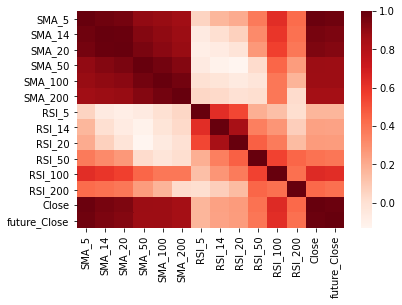

  0%|          | 0/288 [00:00<?, ?it/s]

NameError: name 'go' is not defined

In [25]:
def get_pca(data,n):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(data.iloc[:,:-2])
    principalDf = pd.DataFrame(data = principalComponents)
    principalDf.index = data.index
    principalDf[data.columns[-2]] = data[data.columns[-2]]
    principalDf[data.columns[-1]] = data[data.columns[-1]]
    return principalDf


def LSTM_finetune_pca(df_complete,memory_size = 5 ,training_size = 0.7,epochs=75,batch_size=64,prediction=False):
    if(prediction):
        training_size = 1.0
    model_Key_Value = {}
    df = df_complete.iloc[:-1]
    
    df_processed_memory = data_to_input_find_missing(df_complete,n_in = memory_size)

    df_processed = df_processed_memory.iloc[:-1]
    xfuture = df_processed_memory.iloc[-1]
    m,n = df_processed.shape
    columns = df_processed.columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_processed.values)
    df_scaled = pd.DataFrame(scaler.transform(df_processed.values),columns=df_processed.columns)
    xfuture_scaled = np.array([scaler.transform([xfuture.values])[0][:-1]])
    
    train_size = int(training_size*len(df_scaled))
    test_size = int(len(df_scaled)-train_size)
    df_values = df_scaled.values
    train_dataset = df_values[:train_size, :]
    test_dataset = df_values[train_size:, :]
    xtrain, ytrain = train_dataset[:,0:n-1], train_dataset[:,n-1]
    
    xtest, ytest= test_dataset[:,0:n-1], test_dataset[:,n-1]
    x_train = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    x_test = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    x_future = xfuture_scaled.reshape((xfuture_scaled.shape[0], 1, xfuture_scaled.shape[1]))

    key = "model_"+str(datetime.datetime.timestamp(datetime.datetime.now()))
    model_Key_Value[key] =  Sequential()
    model_Key_Value[key].add(LSTM(epochs, input_shape=(x_train.shape[1], x_train.shape[2])))
    model_Key_Value[key].add(Dense(1))
    model_Key_Value[key].compile(loss='mae', optimizer='adam')
    model_Key_Value[key].build(input_shape=(x_train.shape[1], x_train.shape[2])) 
    
    history_same = model_Key_Value[key].fit(x_train, ytrain, epochs=epochs, batch_size=batch_size, validation_data=(x_test, ytest),verbose=0)
    
    
    columns = df_processed.columns

    ypred_future = model_Key_Value[key].predict(x_future)
    ypred_future_inv = inv_transform(scaler,ypred_future,columns[-1],columns)
    
    ypred_train = model_Key_Value[key].predict(x_train)
    ypred_train_inv = inv_transform(scaler,ypred_train,columns[-1],columns)
    ytrain_same_cv_inv = inv_transform(scaler,ytrain,columns[-1],columns)
    
    if( not prediction):
        ypred_test = model_Key_Value[key].predict(x_test)
        ypred_test_inv = inv_transform(scaler,ypred_test,columns[-1],columns)
        ytest_same_cvn = ytest.reshape((len(ytest), 1))
        ytest_same_cv_inv = inv_transform(scaler,ytest,columns[-1],columns)
        
        rmse_same_cv = np.sqrt(mean_squared_error(ytest_same_cv_inv, ypred_test_inv))
        
        return (model_Key_Value[key],rmse_same_cv,ypred_train_inv,ypred_test_inv,ypred_future_inv[0])
    
    rmse_same_cv_train = np.sqrt(mean_squared_error(ytrain_same_cv_inv, ypred_train_inv))
        
    return (model_Key_Value[key],rmse_same_cv_train,ypred_train_inv,None,ypred_future_inv[0])
    
    
    

def Fine_Tuning_FeatureEngineering(stock):
    data = stock_close[[stock]]
    data.columns = ["Close"]
    df_complete = GetSMA_RSI_indicators(data)
    display(df_complete.tail())
    df = df_complete.iloc[:-1]
    print(len(df.columns))
    cor = df_complete.corr()
    sns.heatmap(cor, cmap=plt.cm.Reds)
    plt.show()
    epochs = [50,75,100]
    batch_sizes = [32,64,72]
    memory_size = [3,5,7,10]
    n_features_pca = list(range(2,10))
#     epochs = [75]
#     batch_sizes = [50]
#     memory_size = [2]
#     n_features_pca = list(range(2,10,10))

    min_error= float("Inf")
    min_errorIndex = -1
    min_errorModel = None
    min_errorParams = None
    best_yPred_train = []
    best_yPred_test = []
    y_future_best = []
    Param_Tuning = list(itertools.product(epochs,batch_sizes,memory_size,n_features_pca))
    number_of_iterations = len(Param_Tuning)
    for i,param in tqdm_notebook(list(enumerate(Param_Tuning))):
        principalDf = get_pca(df_complete,param[3])
        model,rsme,ypred_train,ypred_test,y_future = LSTM_finetune_pca(principalDf,memory_size = param[2] ,training_size = 0.7,epochs=param[0],batch_size=param[1],prediction=False)
        if(rsme<min_error):
            min_errorIndex = i
            min_error = rsme
            min_errorModel = model
            min_errorParams = param
            best_yPred_train = ypred_train
            best_yPred_test = ypred_test
            y_future_best = y_future
    df["Y_pred_train"] = [np.nan]*df.shape[0]
    df["Y_pred_test"] = [np.nan]*df.shape[0]
    df["Y_pred_train"] = pd.Series([i[0] for i in best_yPred_train.reshape((len(best_yPred_train), 1))], index=df.index[min_errorParams[2]:len(best_yPred_train)+min_errorParams[2]])
    df["Y_pred_test"] = pd.Series([i[0] for i in best_yPred_test.reshape((len(best_yPred_test), 1))], index=df.index[len(best_yPred_train)+min_errorParams[2]:])

    fig = go.Figure()
#     display(df.head())
    fig.add_trace(go.Scatter(x=df_complete.index[1:], y=df["future_Close"], mode='lines', name='Actual Price'))
    fig.add_trace(go.Scatter(x=df_complete.index[1:], y=df["Y_pred_train"], mode='lines', name='Predicted Prices(train)'))
    fig.add_trace(go.Scatter(x=df_complete.index[1:], y=df["Y_pred_test"], mode='lines', name='Predicted Prices(test)'))
    fig.show()
    model,score,Y_Pred,_,prediction = LSTM_finetune_pca(get_pca(df_complete,min_errorParams[3]),memory_size = min_errorParams[2] ,training_size = 0.7,epochs=min_errorParams[0],batch_size=min_errorParams[1],prediction=True)
    print("Best Possible future(entire Train) : ",prediction)
    df["Y_pred_Complete"] = pd.Series([i[0] for i in Y_Pred.reshape((len(Y_Pred), 1))], index=df.index[min_errorParams[2]:len(Y_Pred)+min_errorParams[2]])
    
    return (df,score, model , min_errorParams)

_  = (Fine_Tuning_FeatureEngineering("AAPL"))
print("Error : ",_[1])
print("best Parameters : ",_[-1])

In [ ]:
_  = (Fine_Tuning_FeatureEngineering("AMZN"))
print("Error : ",_[1])
print("best Parameters : ",_[-1])

In [ ]:
stock_data

In [ ]:
end